El sistema tiene como objetivo la detección de movimiento en un área como pasillo o habitación con una sola entrada y una secuencia de acceso líneal. 
Para efectos de prueba se consideraron tres para detección. Siendo un equipo el principal a la entrada de la habitación o al inicio del pasillo que iniciará la detección del movimiento.

Realizamos la conexion al telefono en el puerto 9999 corriendo el servidor en el telefono SL4A

In [1]:
!adb forward tcp:9999 tcp:49999

Se verifica que el dispositivo sea detectable por la computadora.

In [2]:
!adb devices

List of devices attached
02157df288f41912	device



Se importan las librerías necesarias acorde a lo visto en la clase del día 3 para el análisis de imágenes.

In [ ]:
%matplotlib inline
import time 
import android
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys, os,re
import pprint

Se ocupan las funciones mse y compare imágenes para sacar el valor de la diferencia(error) entre dos imágenes determinadas.

In [ ]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
 
def compare_images(imageA, imageB, title):
	# compute the mean squared error and structural similarity
	# index for the images
	m = mse(imageA, imageB)
	print  str(m)
	# s = ssim(imageA, imageB)
 
	# setup the figure
	fig = plt.figure(title)
	#plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
 
	# show first image
	ax = fig.add_subplot(1, 2, 1)
	plt.imshow(imageA, cmap = plt.cm.gray)
	plt.axis("off")
 
	# show the second image
	ax = fig.add_subplot(1, 2, 2)
	plt.imshow(imageB, cmap = plt.cm.gray)
	plt.axis("off")
 
	# show the images
	plt.show()
	return m

Se genera una función de nombre revisar, la cual es la que realiza la ejecución de nuestro sistema de detección.

Se determina que el sistema tomará imágenes cada 8 segundos y comparará las últimas dos imágenes para verificar si hay
cambios entre ellas. En caso de que el sistema encuentre un cambio(es decir un valor de mse mayor a 1000). Cuando 
se detecte un cambio entre imágenes el equipo empezará una secuencia de 5 fotos con intervalos de 1 segundo entre cada
una de ellas. A la vez mandará un mensaje sms hacia el siguiente equipo en la cadena de detección el cual iniciará su secuencia de detección de movimiento al recibir el mensaje indicado.
Si el equipo deja de detectar cambios entre imágenes volverá a tomar imágenes cada 8 segundos en espera de volver a 
detectar movimiento.

2106.31929097


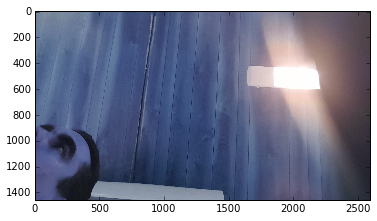

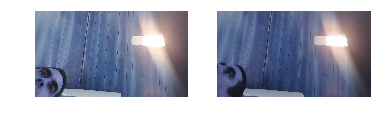

1860.16200423


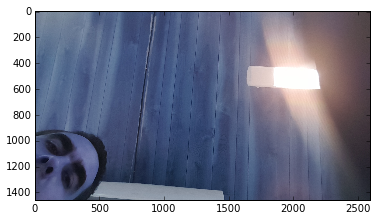

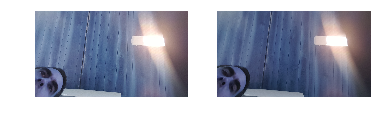

604.949876374


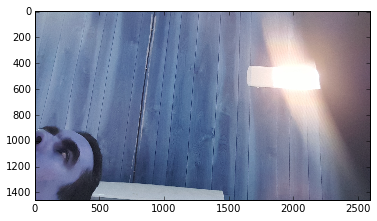

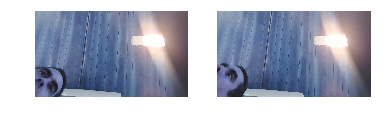

801.497612153


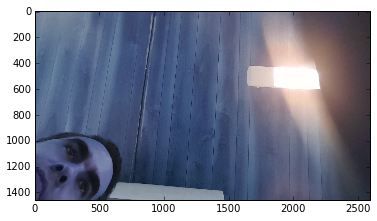

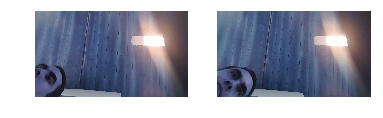

Hecho sin errores ...


In [3]:
def revisar():
	droide=android.Android()
	counter=1
	delay=5
	numofShots = 5
	delayBetweenShots=8
	couterDecteccion=1
	droide.ttsSpeak('Tomando fotos')
	time.sleep(int(1))
	droide.dialogCreateAlert('Seleccione','Detener?')
	droide.dialogSetPositiveButtonText('Si')
	droide.dialogSetNegativeButtonText('No')
	droide.dialogShow()
	#s3 = droide.sensorsGetLight()
	#print  s3[1]
	mensaje=''
	msgs = droide.smsGetMessages(False) 
	total=droide.smsGetMessageCount(False).result
	contador=0
	while contador<total:
		if msgs.result[contador]['address']=='2851087970' or msgs.result[contador]['address']=='2281248059' or msgs.result[contador]['address']=='2299848788':
			mensaje= msgs.result[contador]['body']
		contador+=1
	response = droide.dialogGetResponse().result
	marcado=0
	while response['which']=='negative'  or mensaje!='': 
		droide.ttsSpeak('Tomando foto 1')
		droide.cameraCapturePicture('/sdcard/DCIM/CAMERA/programa/foto_'+ str(couterDecteccion)+ '_.jpg',1,1)
		os.system('adb pull /sdcard/DCIM/CAMERA/programa/foto_'+ str(couterDecteccion)+ '_.jpg')
		pic = os.path.join('.','foto_'+  str(couterDecteccion)+ "_.jpg")
		img1 = cv2.imread(pic)
		couterDecteccion +=1
		time.sleep(int(delayBetweenShots))
		#droide.ttsSpeak('Tomando foto 2')
		droide.cameraCapturePicture('/sdcard/DCIM/CAMERA/programa/foto_'+ str(couterDecteccion)+ '_.jpg',1,1)
		os.system('adb pull /sdcard/DCIM/CAMERA/programa/foto_'+ str(couterDecteccion)+ '_.jpg')
		pic = os.path.join('.','foto_'+  str(couterDecteccion)+ "_.jpg")
		couterDecteccion +=1
		img2 =  cv2.imread(pic)
		plt.imshow(img1)
		plt.imshow(img2)
		i= img1.copy()
		i2=img2.copy()
		diferente = compare_images(i,i2,'pruebacompare')
		counter=0
		if diferente >1000:
			droide.ttsSpeak('Imagen con cambio')
			if marcado==0:
				droide.smsSend('2281248059', 'Intruso')    
				marcado=1
			while counter <= int(numofShots):
				droide.ttsSpeak('Tomando foto carrete '+ str(counter))
				droide.cameraCapturePicture('/sdcard/DCIM/CAMERA/programa/fotoC_'+ str(counter)+ '_.jpg',1,1)
				os.system('adb pull /sdcard/DCIM/CAMERA/programa/fotoC_'+ str(counter)+ '_.jpg')
				pic = os.path.join('.','fotoC_'+  str(counter)+ "_.jpg")
				counter +=1
				img2 =  cv2.imread(pic)
				plt.imshow(img1)
				plt.imshow(img2)
				i= img1.copy()
				i2=img2.copy()
				diferente =compare_images(i,i2,'pruebacompare')
				if diferente <1000:
					droide.ttsSpeak('Ya no se ha detectado movimiento')
					break
				time.sleep(int(1))
		#if response['which']=='negative':
		droide.dialogShow()
		response = droide.dialogGetResponse().result
	print 'Hecho sin errores ...'
	del droide    
    
    
revisar()